# Test ellipse fit

## Imports

In [16]:
# Python standard library
import sys
import csv
import os

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events_filtered.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


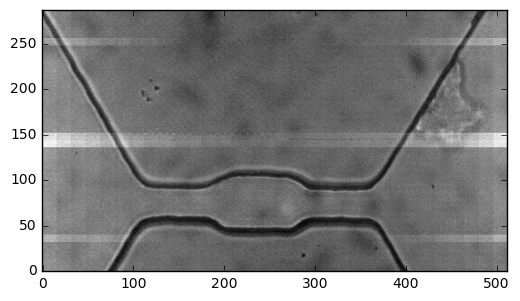

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.00204081  0.99999792]


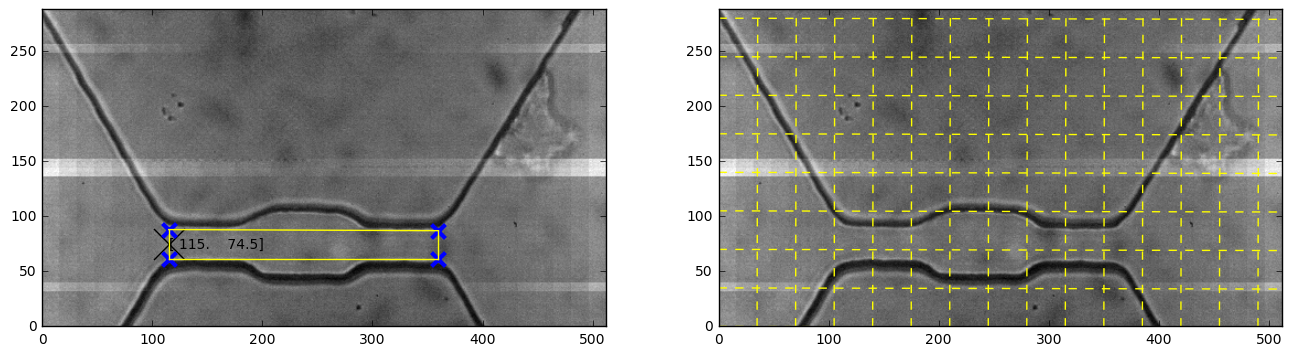

In [5]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [115,88]
c1 = [115,61]
c2 = [360,61]
c3 = [360,87]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Define plotting functions

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

## Define ellipse fitting functions

In [7]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

    
    
    
    
    

preprocessing_steps = []
def preprocess_frame(frame, template_frame, detection, debug = 'none'):

    # Refresh list
    del preprocessing_steps[:]

    

    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_frame = np.copy(frame)

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, frame)


    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(frame - template_frame)


    if debug == 'all':
        print 'negative'
        plot_all(processed_frame, frame)




    #################################
    # Blur
    #################################


    blur_kernel = (3,3)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)





    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)






    #################################
    # Threshold
    #################################

    threshold = .125
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    if debug == 'all':
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)




    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)




    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)

    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)


    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
        
        
        
    
    if debug == 'last':
        plot_all(processed_frame, frame)
        
        
    return processed_frame



def fit_ellipse(processed_frame, debug = False):

    #################################
    # Fit ellipse
    #################################



    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
    
    
    if debug:
        ellipse_center = oi.get_ellipse_center(ellipse)
        ellipse_angle = oi.get_ellipse_angle(ellipse)
        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)





        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes[0]*np.cos(angle)
            y = ellipse_axes[1]*np.sin(angle)
            ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
            ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame



        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

        plt.xlim(0, frame.shape[1])
        plt.ylim(0, frame.shape[0])

        plt.show()
        
    return ellipse



## Find event to test fit on

In [8]:
oi_index = 16
oi_event = oi_events[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf).to_html5_video())

In [ ]:
ellipsess = []
for oi_event in oi_events:
    ellipsess.append([])

(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 0 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 1 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 2 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 3 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 4 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 5 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 6 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 7 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 8 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 9 / 138
(<type 'exceptions.TypeError'>, '<ipython-input-18-94388c29a632>', 15)
	failed on 10 / 138
(<type 'e

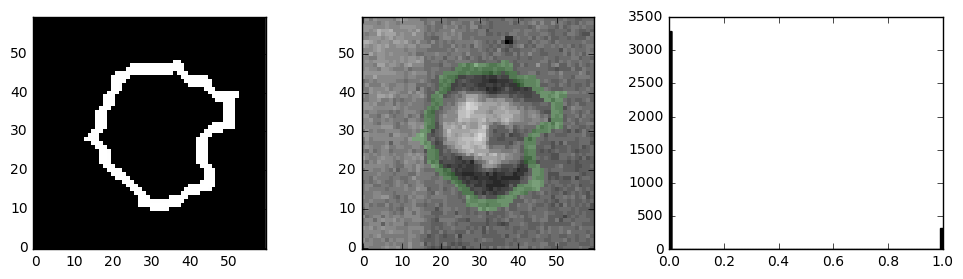

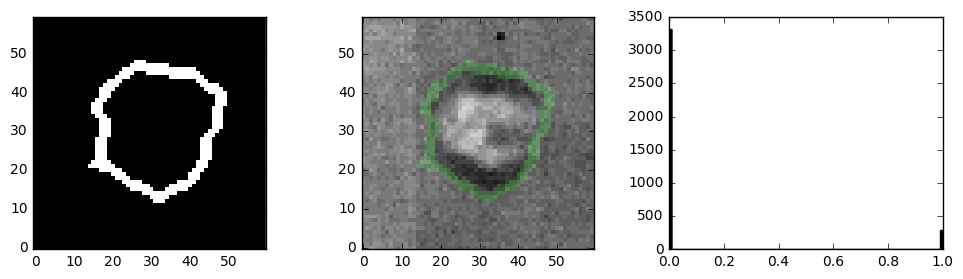

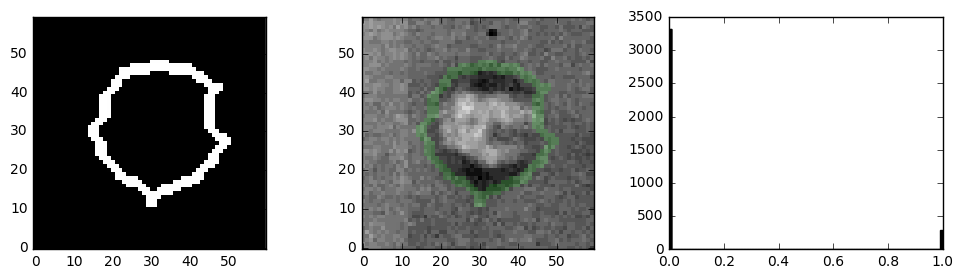

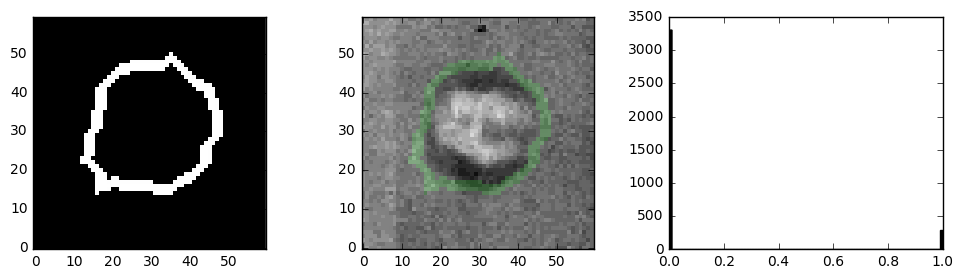

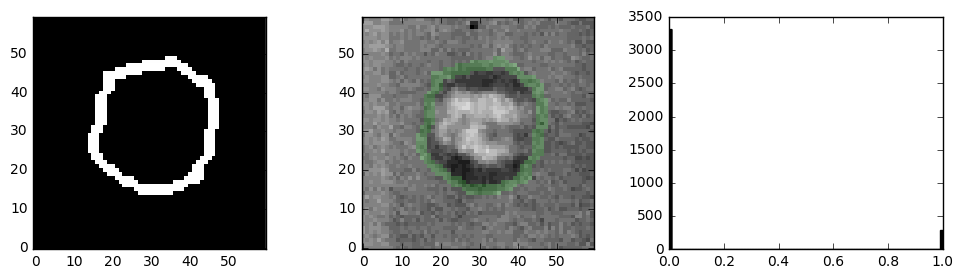

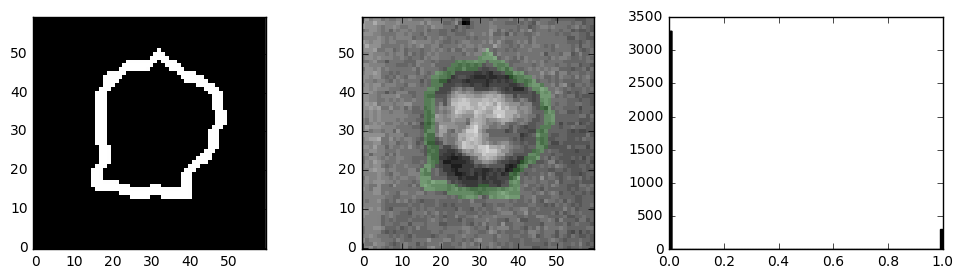

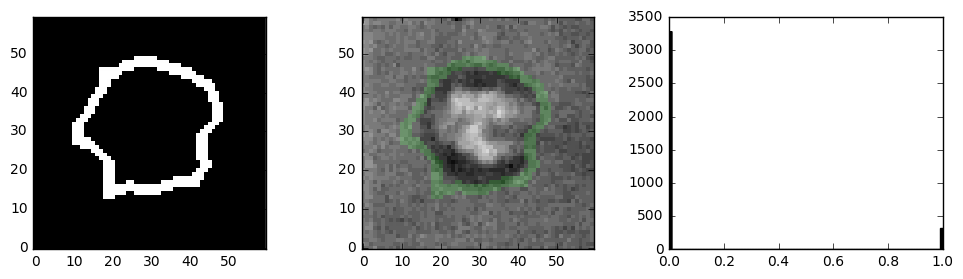

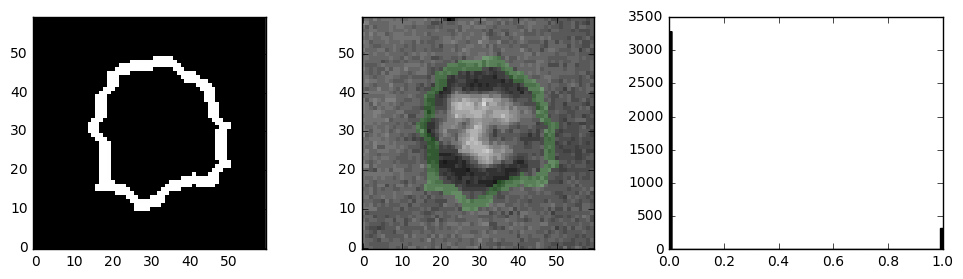

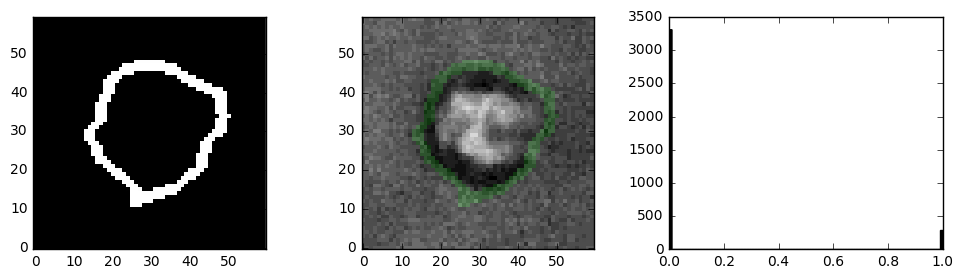

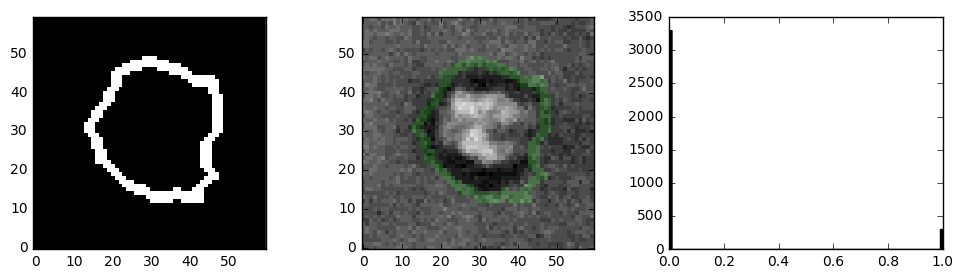

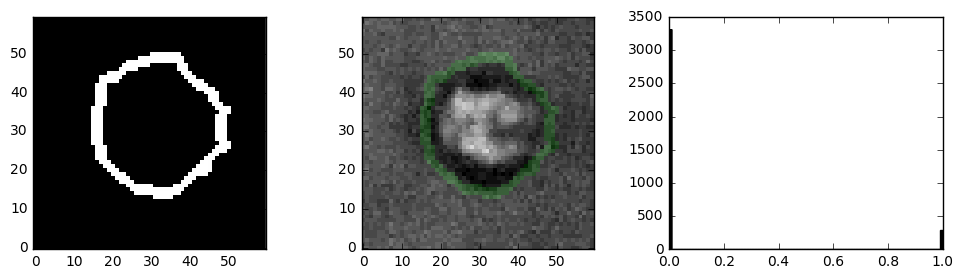

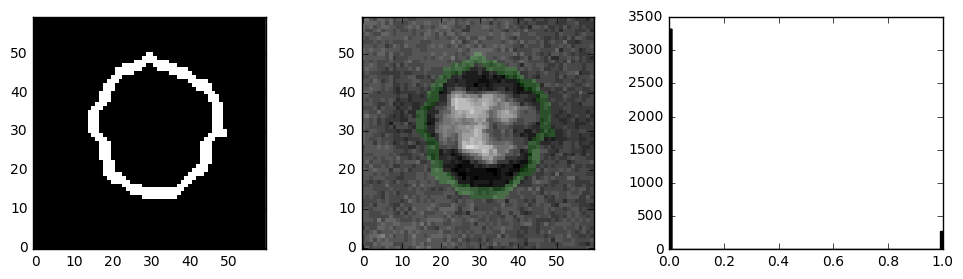

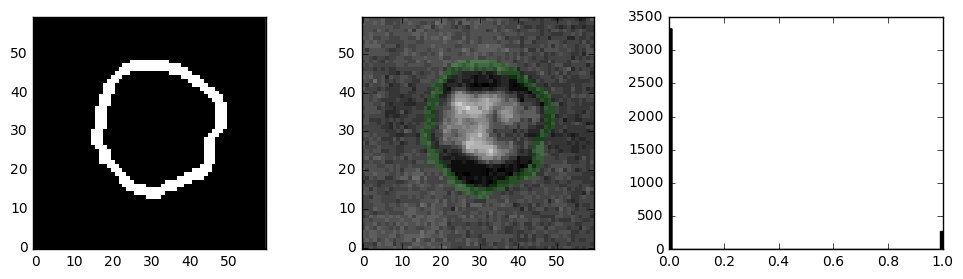

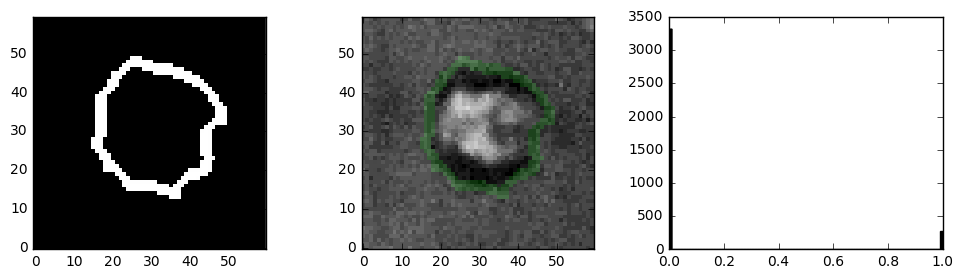

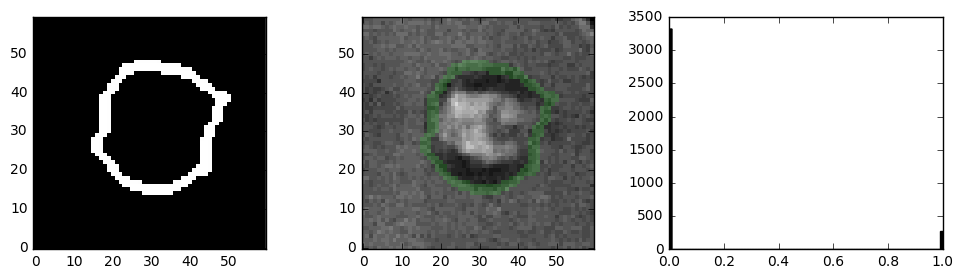

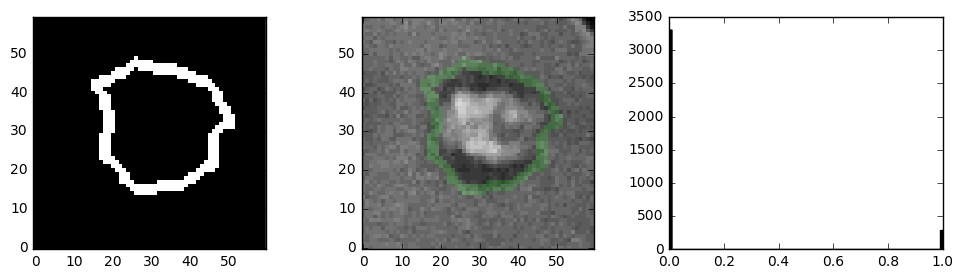

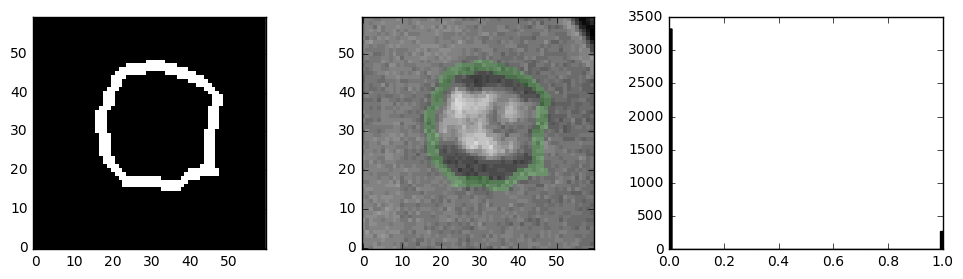

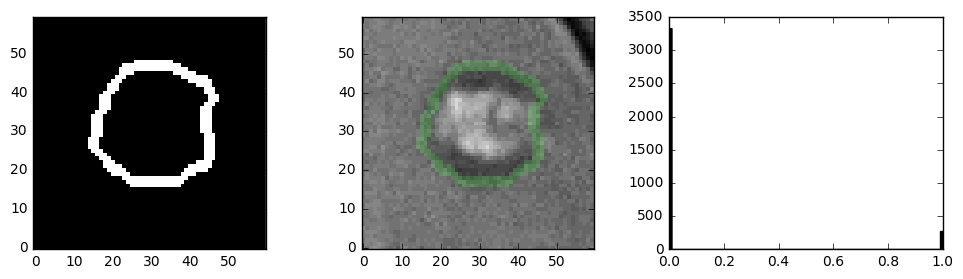

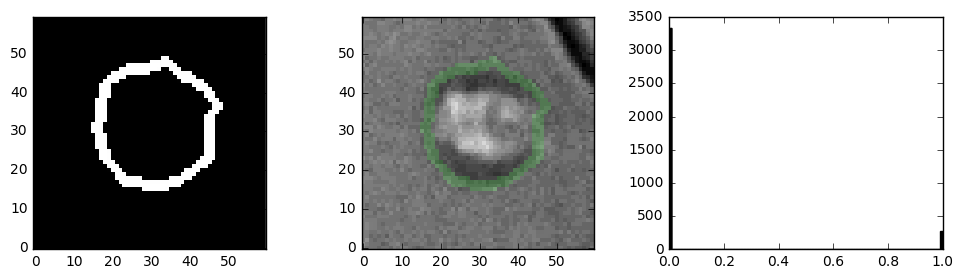

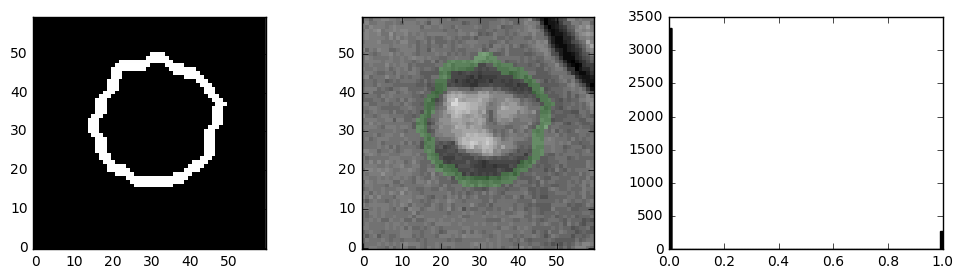

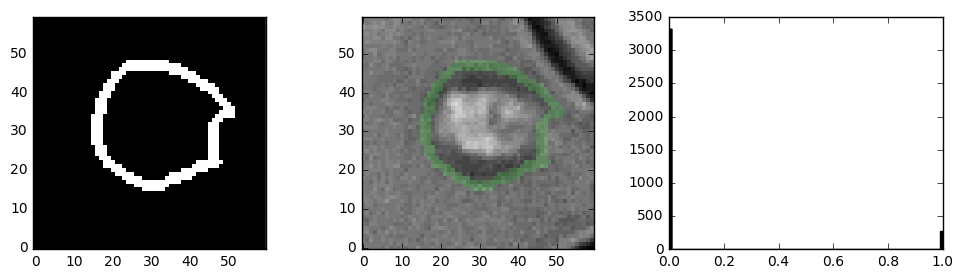

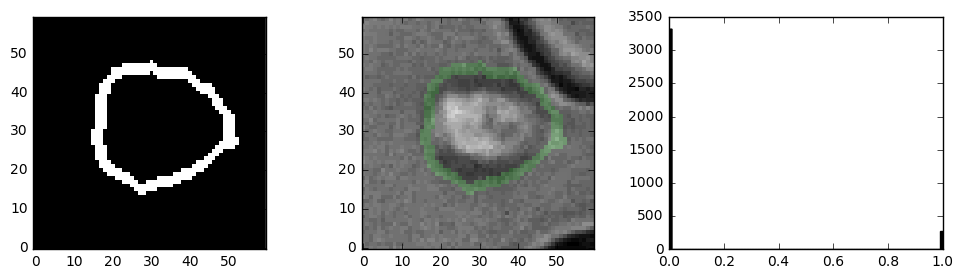

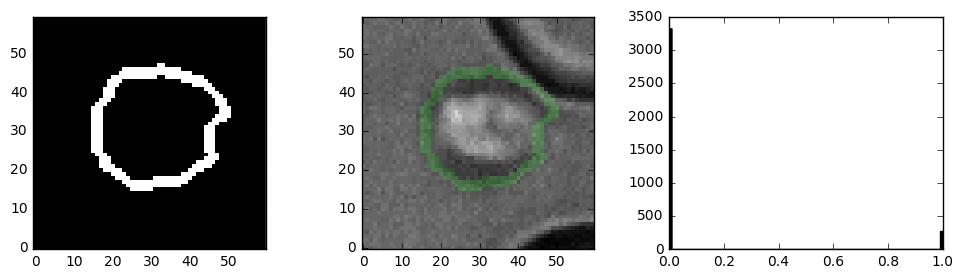

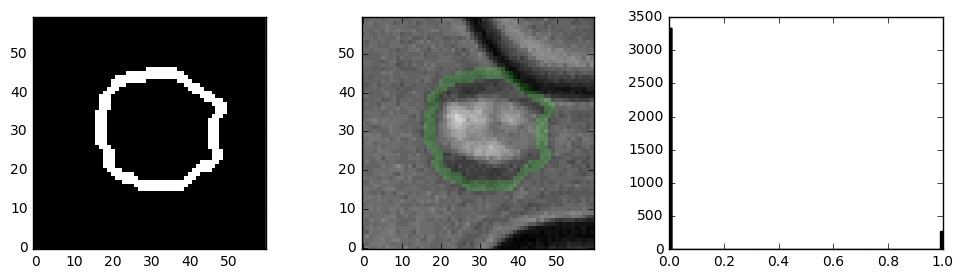

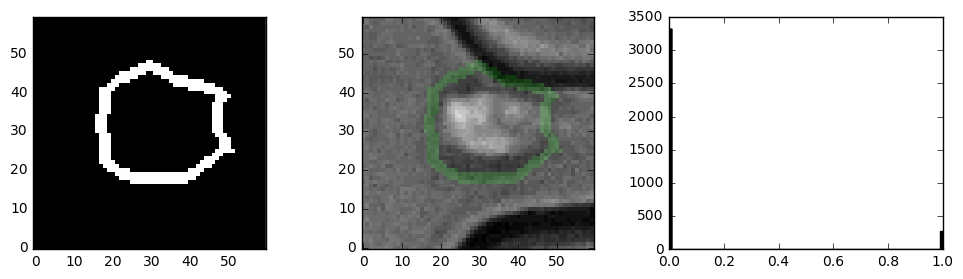

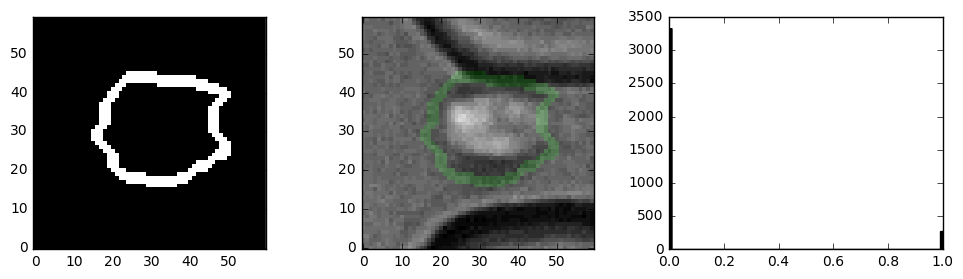

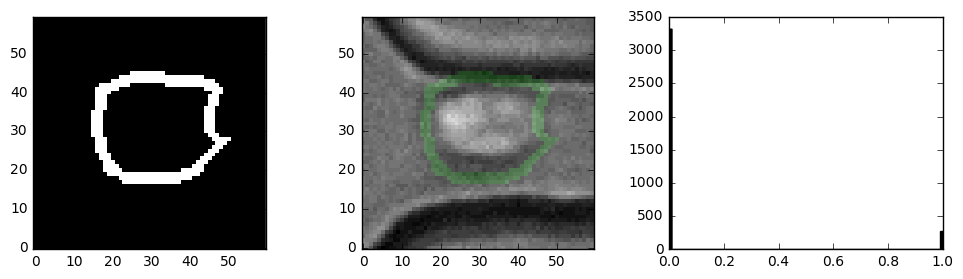

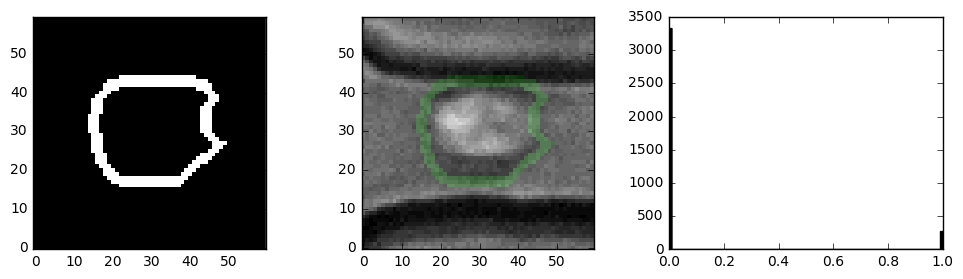

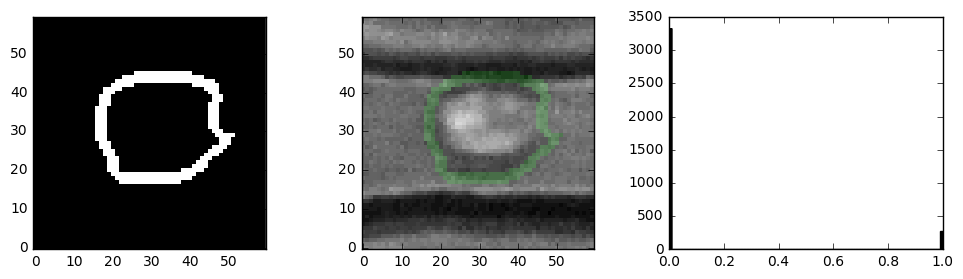

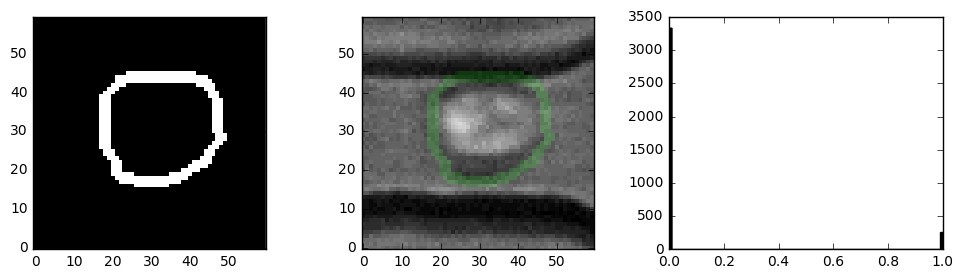

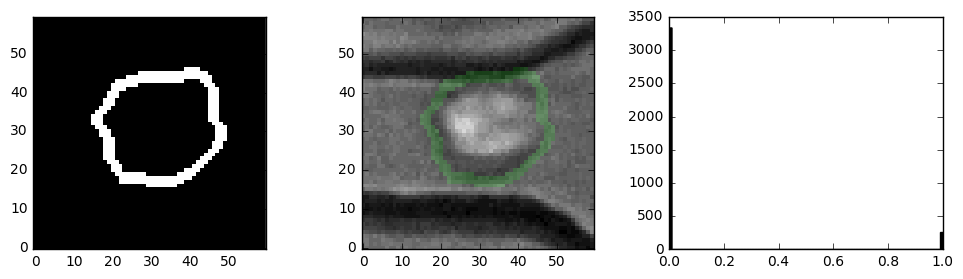

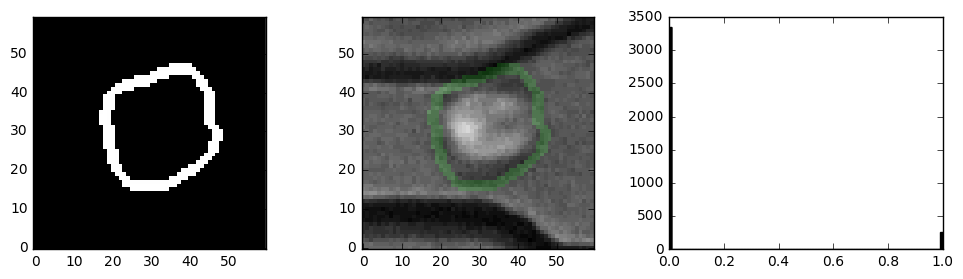

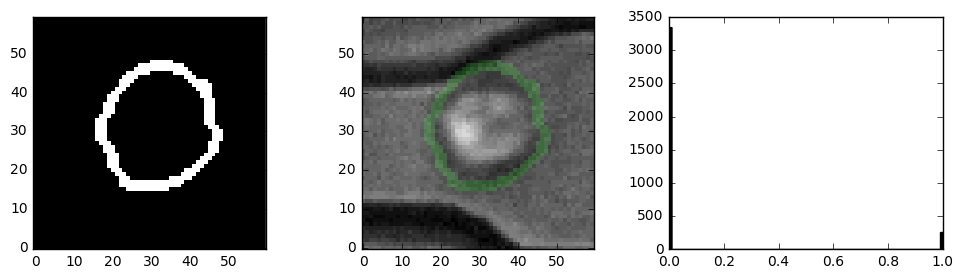

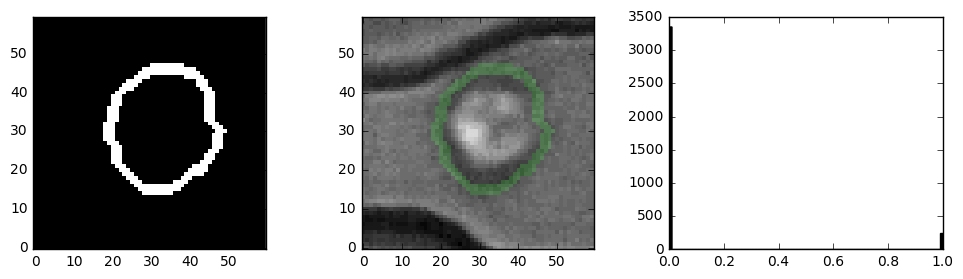

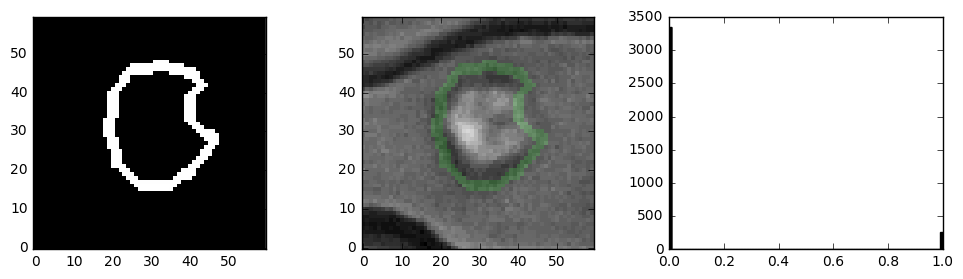

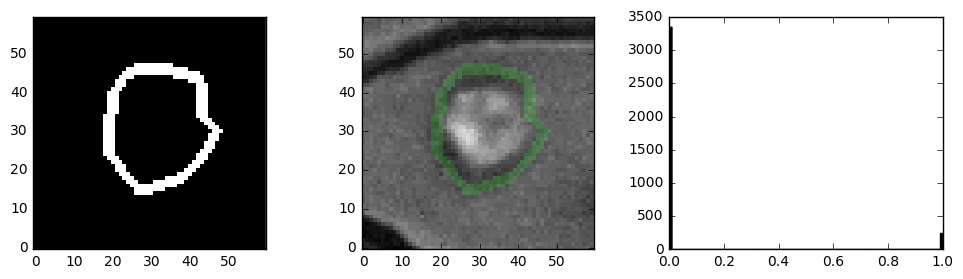

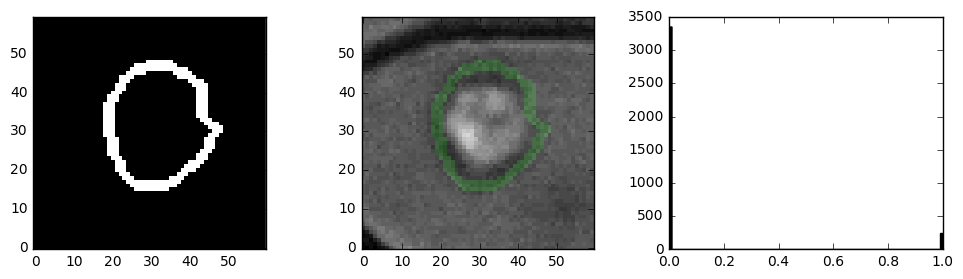

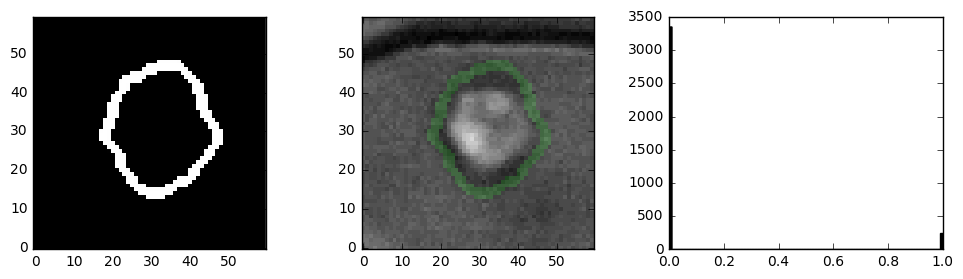

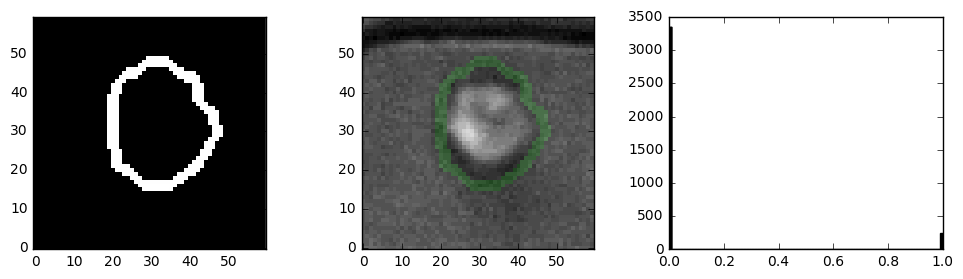

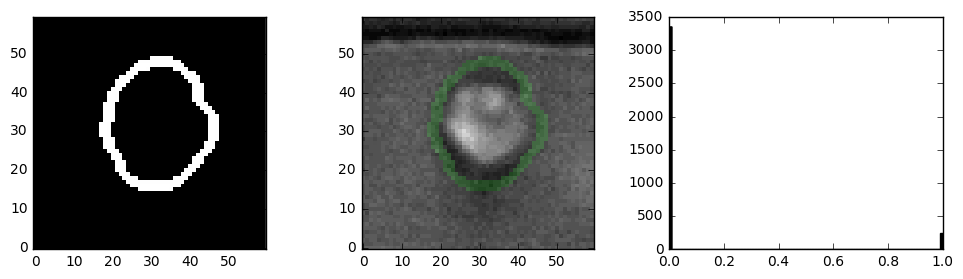

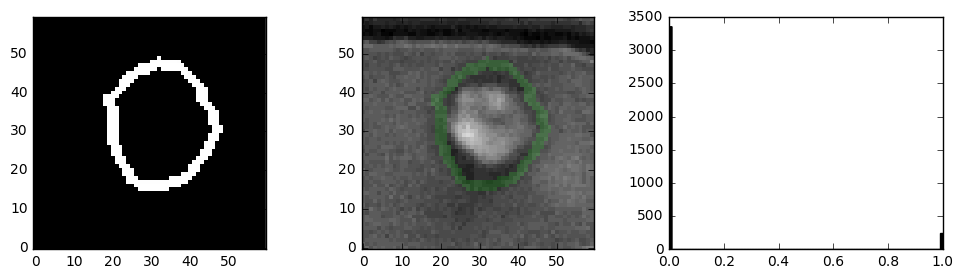

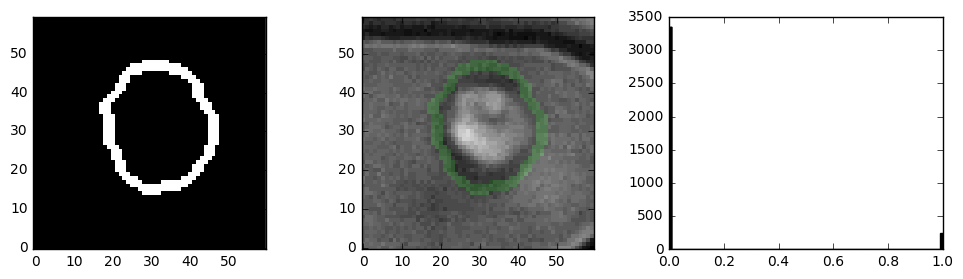

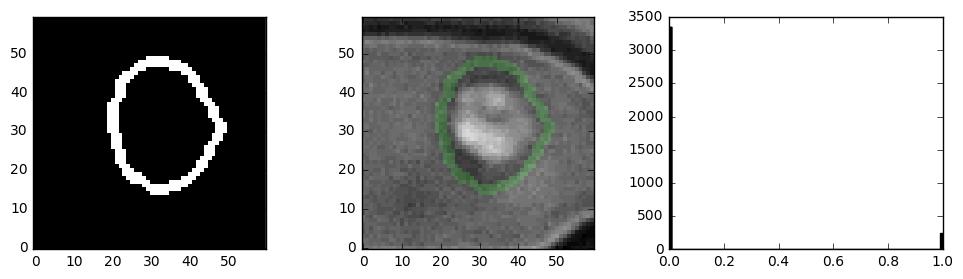

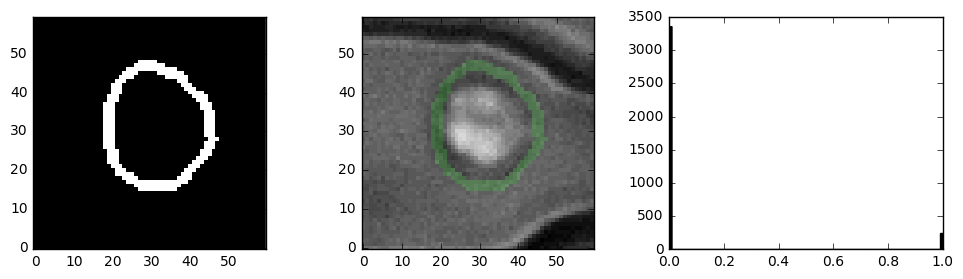

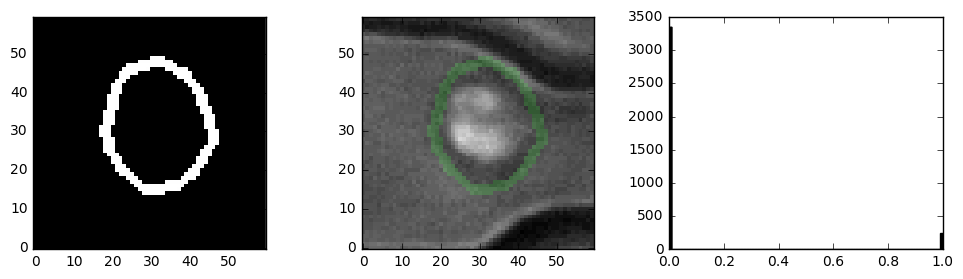

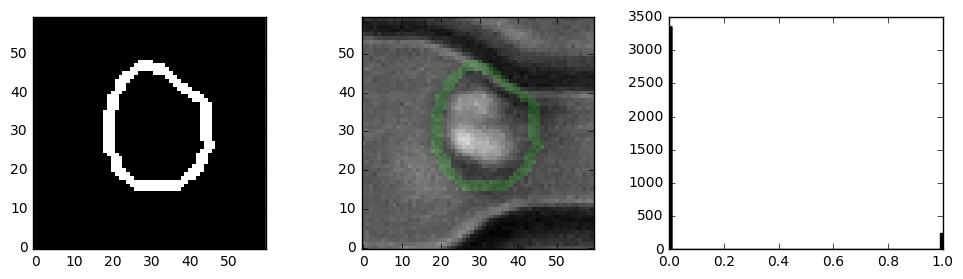

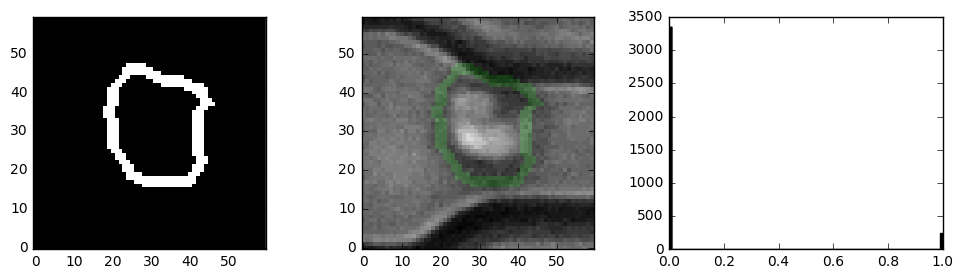

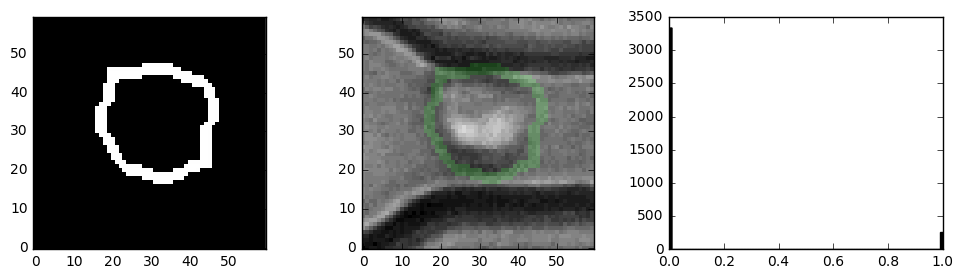

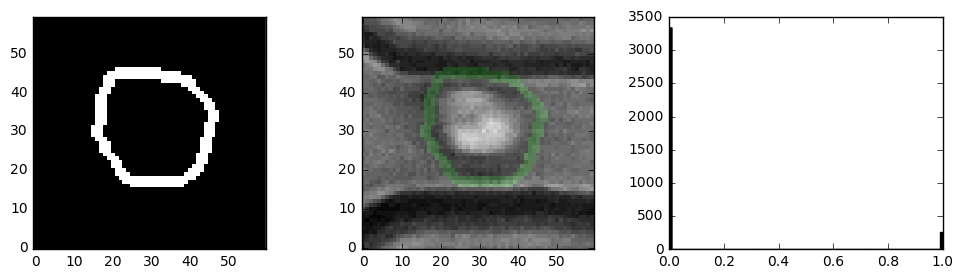

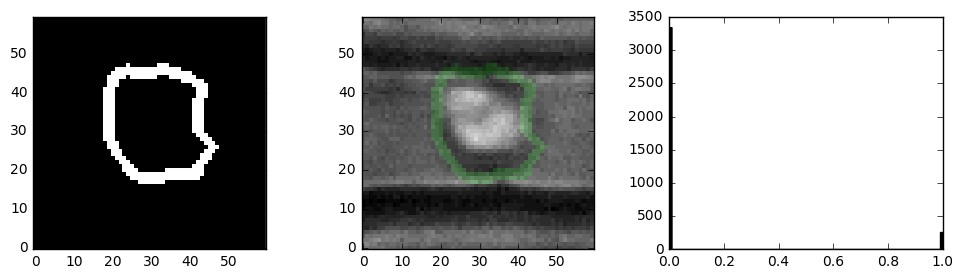

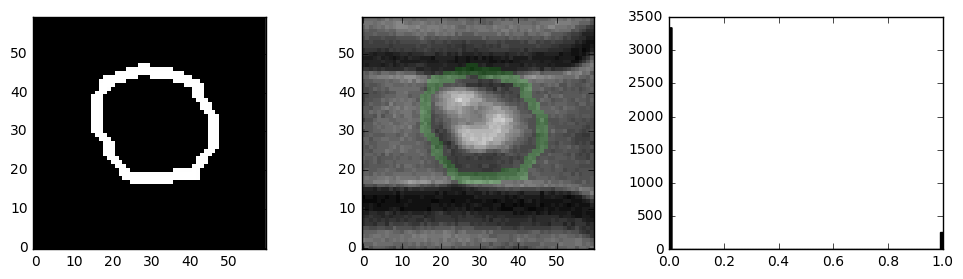

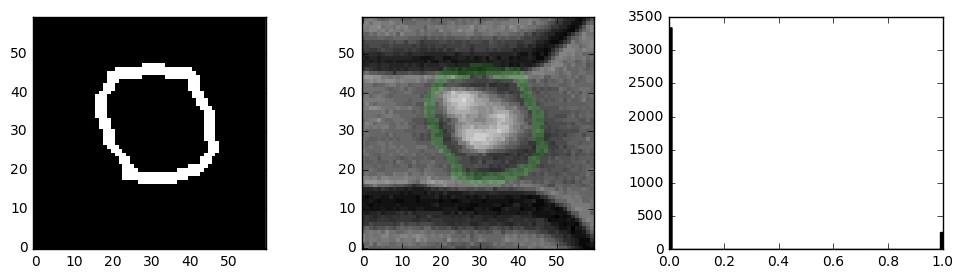

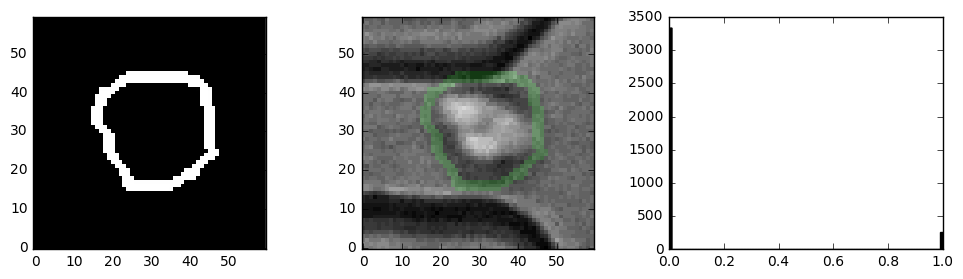

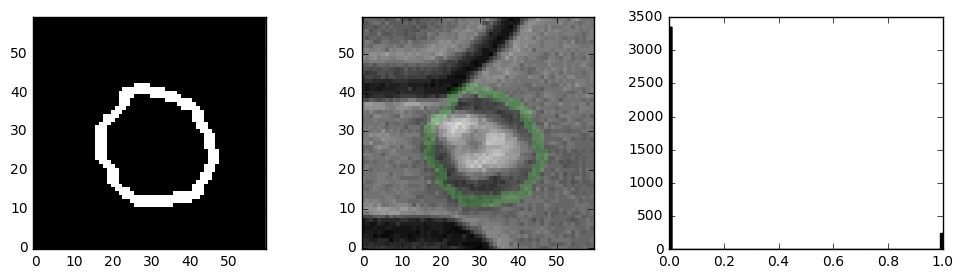

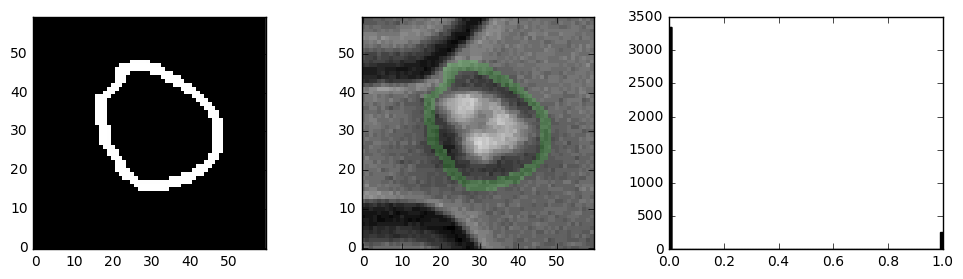

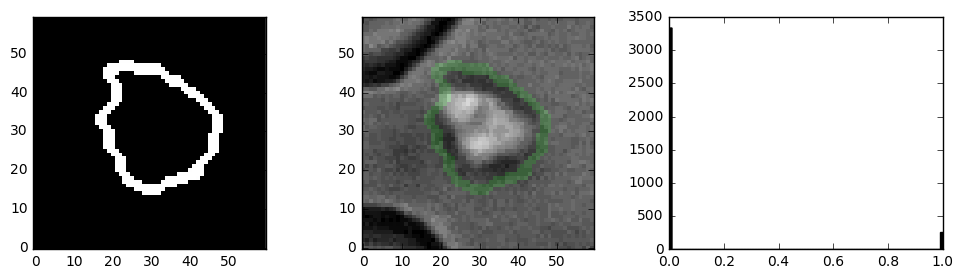

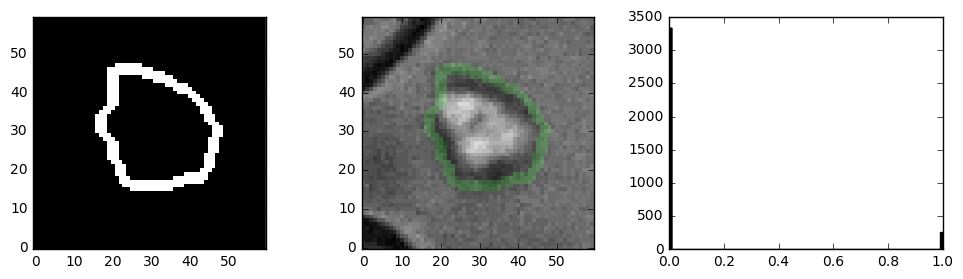

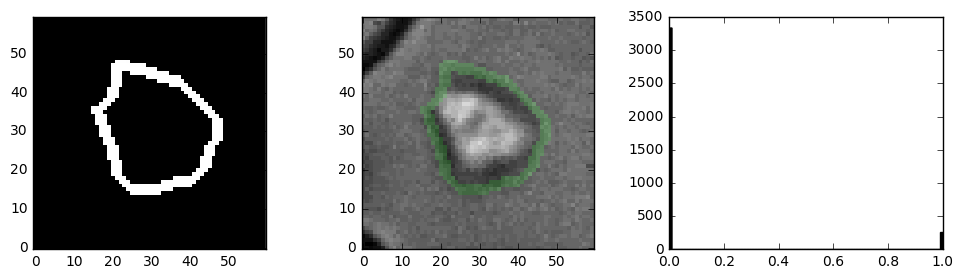

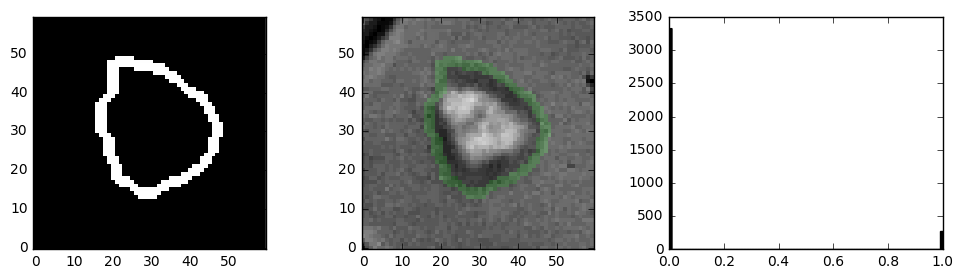

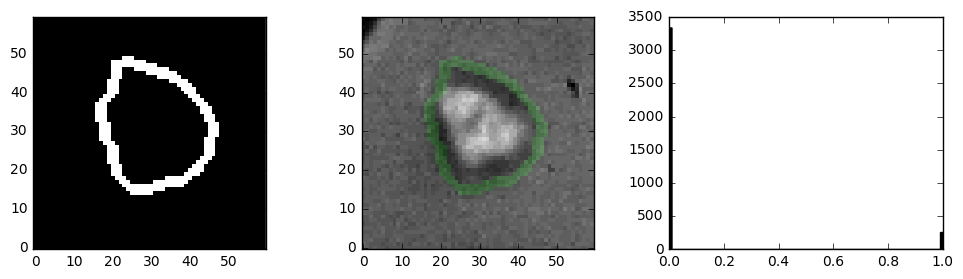

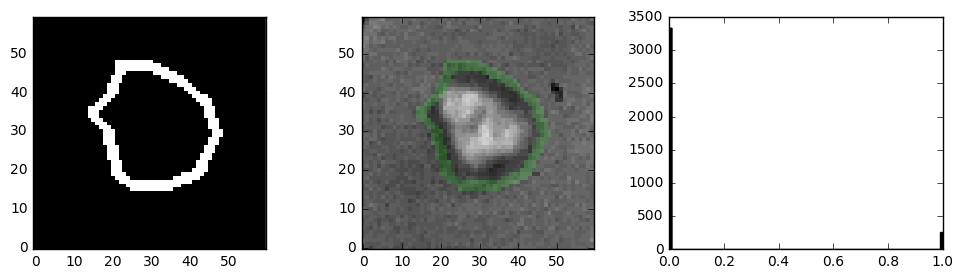

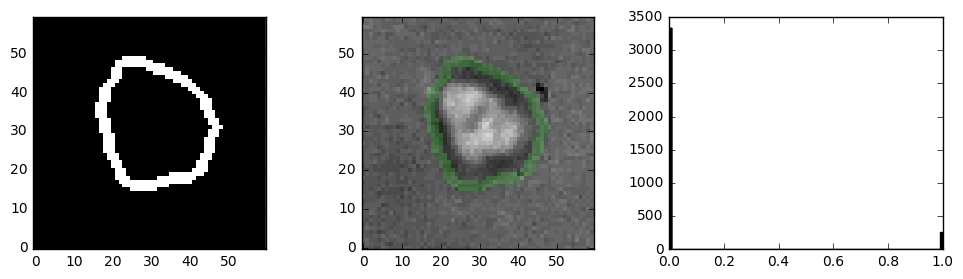

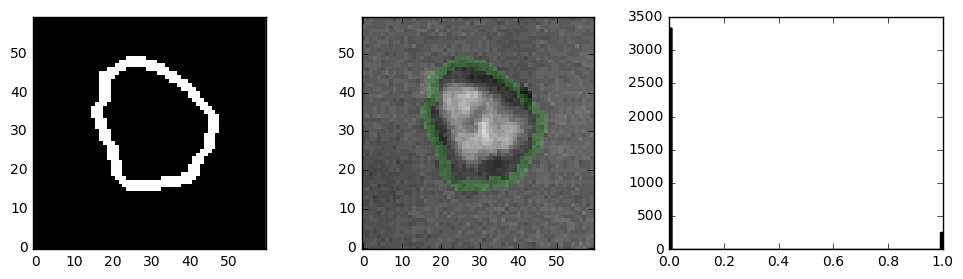

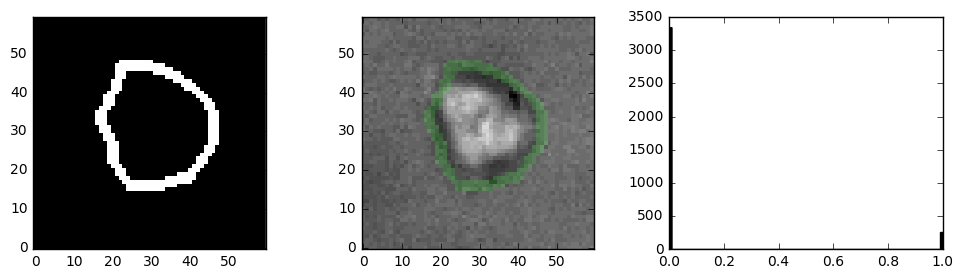

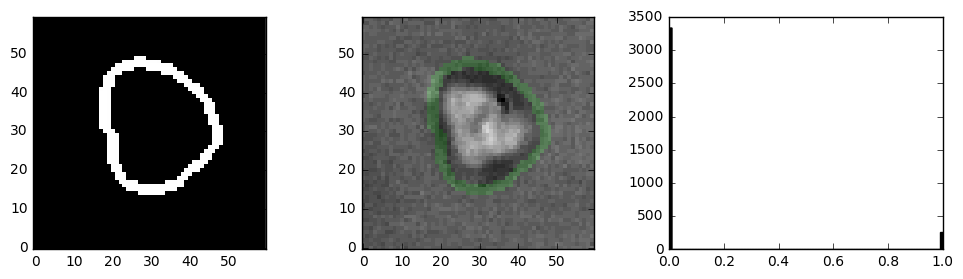

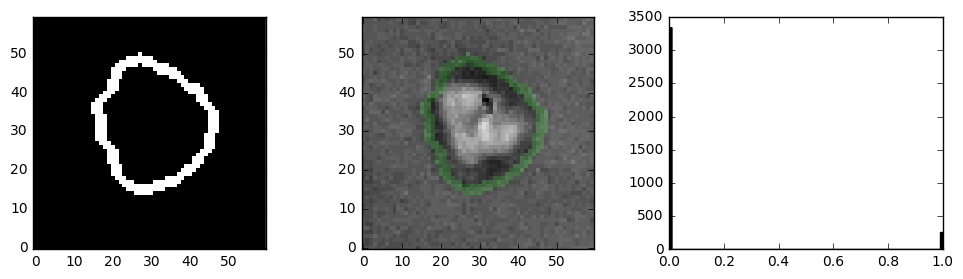

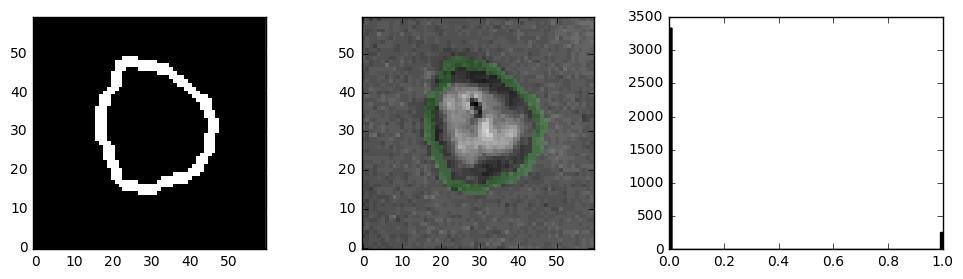

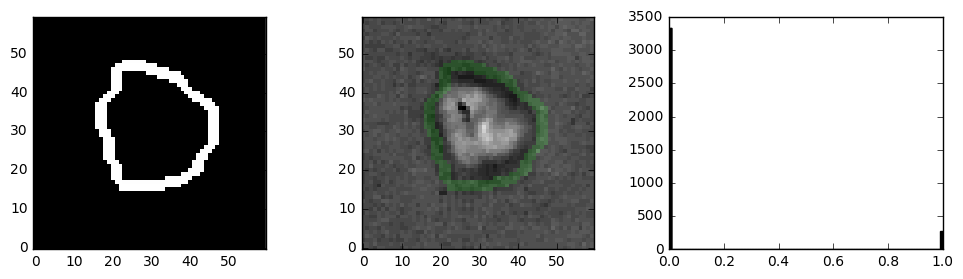

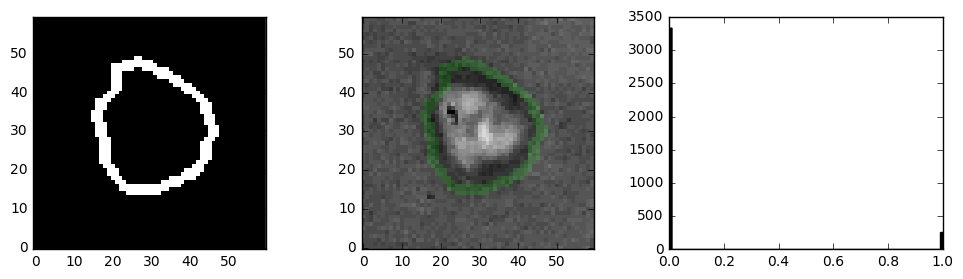

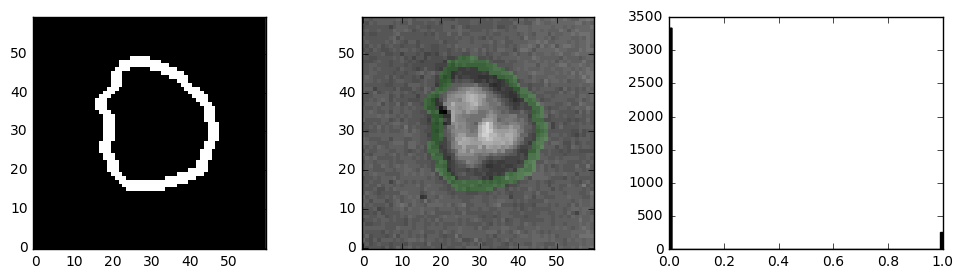

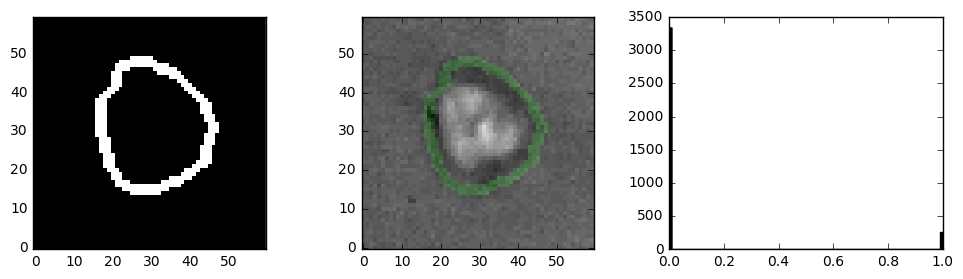

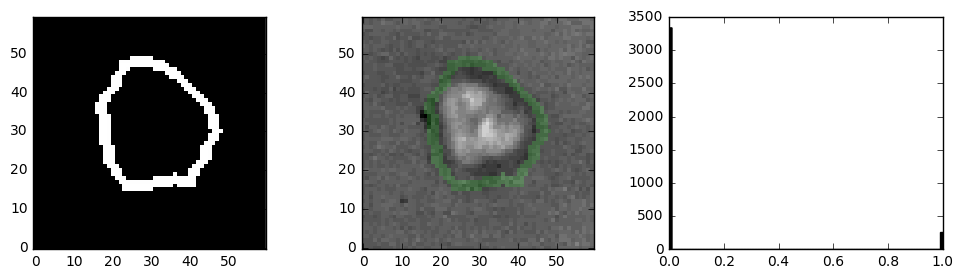

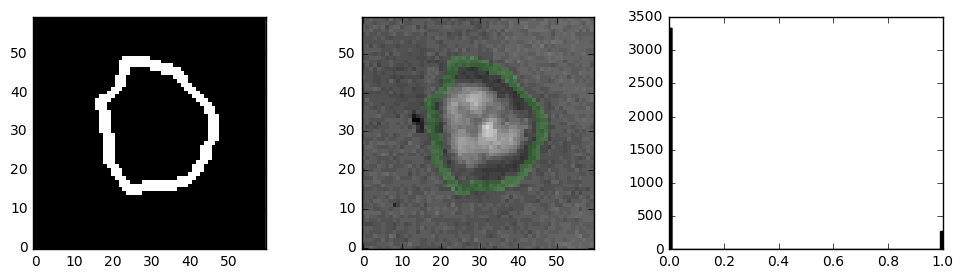

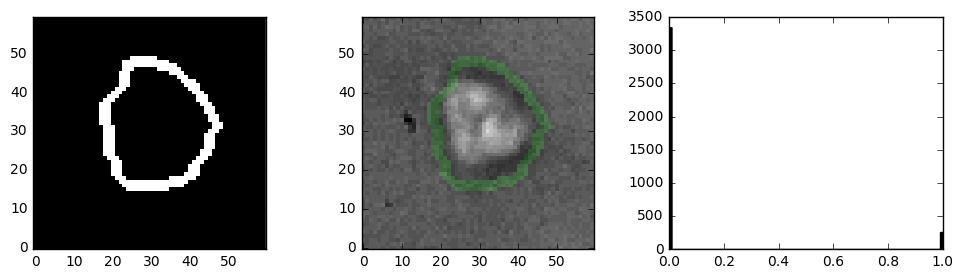

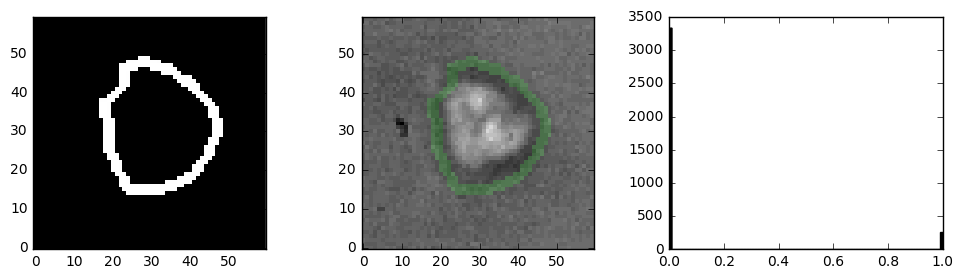

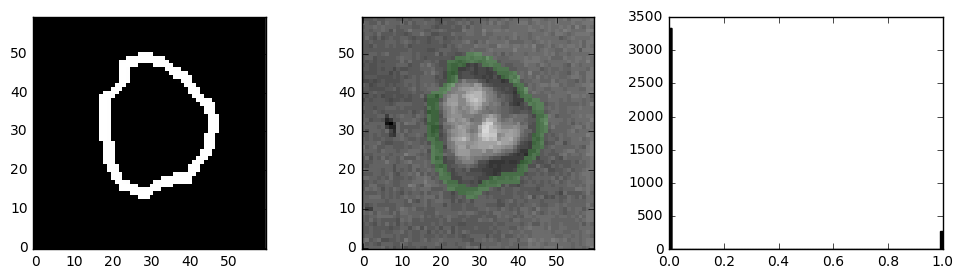

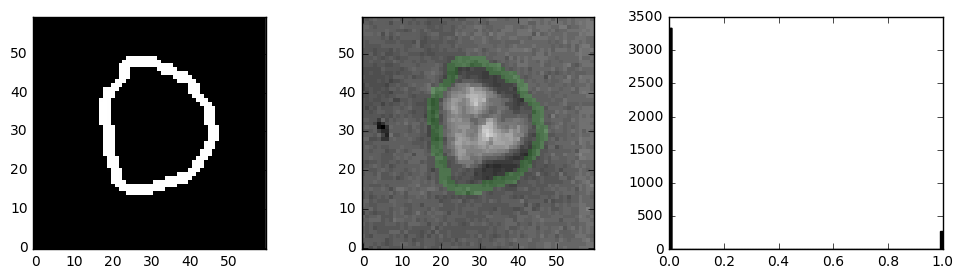

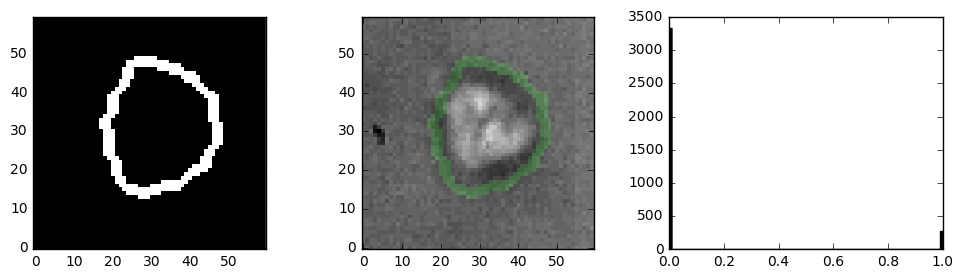

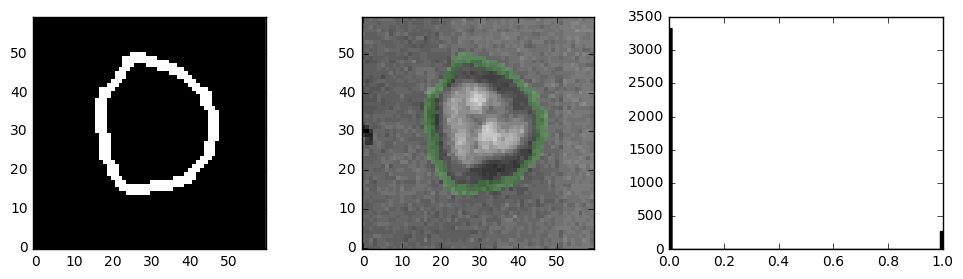

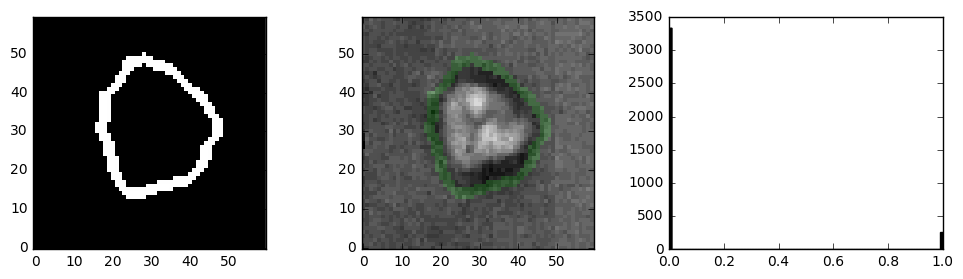

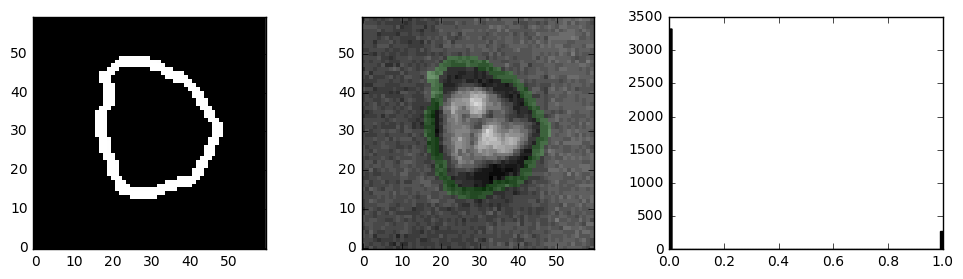

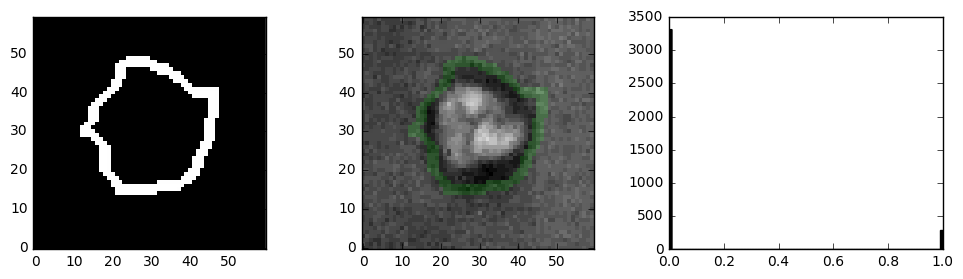

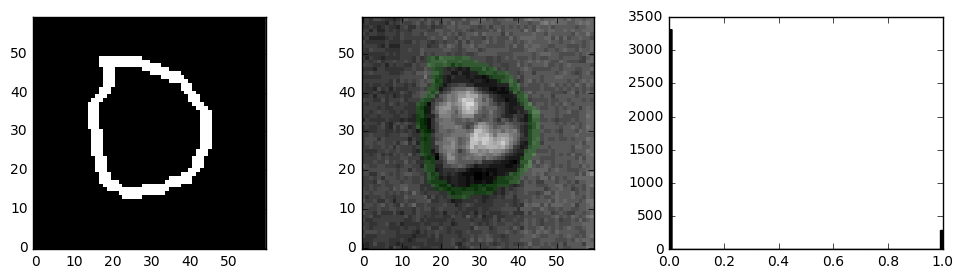

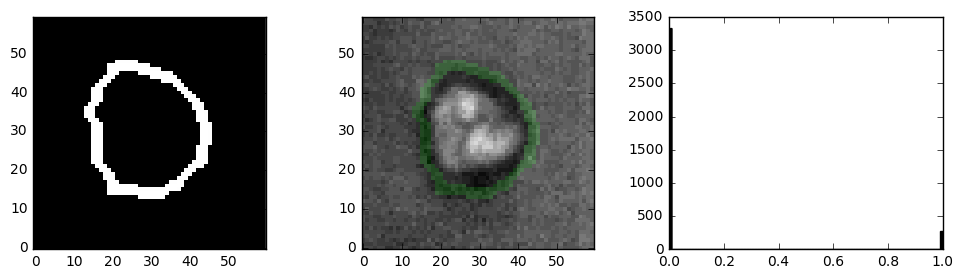

In [ ]:
for j, detection in enumerate(oi_event._detections):
        
    try:

        # Get raw frame
        raw_frame = oi_vid.get_frame(detection._tf)


        # Crop frames
        cropped_frame = crop_frame(raw_frame, detection._px, detection._py, 30)
        cropped_template_frame = crop_frame(template_frame, detection._px, detection._py, 30)


        # Preprocess frame
        processed_frame = preprocess_frame(cropped_frame, cropped_template_frame, detection, debug = 'last')


        # Get ellipse + parameters
        ellipse = fit_ellipse(processed_frame)
        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)
        ellipse_center = oi.get_ellipse_center(ellipse)
        ellipse_center[0] = ellipse_center[0] + (detection._px - 30)
        ellipse_center[1] = ellipse_center[1] + (detection._py - 30)

        ellipse_angle = oi.get_ellipse_angle(ellipse)



    except Exception as e:
        print '\tfailed on', j, '/', len(oi_event._detections)

In [ ]:
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, fname, exc_tb.tb_lineno)